In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from windrose import WindroseAxes

import statsmodels.graphics.tsaplots
import statsmodels.tsa.stattools
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [2]:
from operational_analysis.toolkits import filters
from operational_analysis.toolkits import power_curve

In [3]:
import missingno as msno

In [4]:
# Read data
desc = pd.read_csv('../datasets/original/data_description.csv', sep=';')
data1_pd = pd.read_csv('../datasets/original/la-haute-borne-data-2013-2016.csv', sep=';')
data2_pd = pd.read_csv('../datasets/original/la-haute-borne-data-2017-2020.csv', sep=';')
#data2_pd = data1_pd

In [5]:
desc

,Variable_name,Variable_long_name,Unit_long_name,Comment
0,Q,Reactive_power,kVAr,NaN
1,Ws,Wind_speed,m/s,Average wind speed
2,Va2,Vane_position_2,deg,Second wind vane on the nacelle
3,Git,Gearbox_inlet_temperature,deg_C,NaN
4,Ot,Outdoor_temperature,deg_C,NaN
5,Ws2,Wind_speed_2,m/s,Second anemometer on the nacelle
6,Nf,Grid_frequency,Hz,NaN
7,Nu,Grid_voltage,V,NaN
8,Dst,Generator_stator_temperature,deg_C,NaN
9,Wa_c,Absolute_wind_direction_corrected,deg,NaN


In [6]:
data = pd.concat([data1_pd, data2_pd], axis=0)

In [7]:
data.shape

(1057968, 138)

In [8]:
# Leave only the averaged columns
col = np.array([col for col in data1_pd.columns if 'avg' in col])
colnames_of_interest = np.concatenate([['Wind_turbine_name', 'Date_time'], col])
colnames_of_interest

# Leave all columns
#colnames_of_interest = data.columns
#colnames_of_interest

# Extract columns
data_pd = data[colnames_of_interest]

In [9]:
# Separate turbines
data_R80711 = data_pd[data_pd['Wind_turbine_name']=="R80711"]
data_R80736 = data_pd[data_pd['Wind_turbine_name']=="R80736"]
data_R80790 = data_pd[data_pd['Wind_turbine_name']=="R80790"]
data_R80721 = data_pd[data_pd['Wind_turbine_name']=="R80721"]

In [10]:
# Resample
data_R80711['Date_time'] = pd.to_datetime(data_R80711['Date_time'], format="%Y-%m-%dT%H:%M:%S", utc=True)
data_R80711['Date_time'] = pd.DatetimeIndex(data_R80711["Date_time"])
data_R80711 = data_R80711.resample("1H", on='Date_time').mean()
data_R80711 = data_R80711.reset_index(inplace=False, drop=False)

data_R80736['Date_time'] = pd.to_datetime(data_R80736['Date_time'], format="%Y-%m-%dT%H:%M:%S", utc=True)
data_R80736['Date_time'] = pd.DatetimeIndex(data_R80736["Date_time"])
data_R80736 = data_R80736.resample("1H", on='Date_time').mean()
data_R80736 = data_R80736.reset_index(inplace=False, drop=False)

data_R80790['Date_time'] = pd.to_datetime(data_R80790['Date_time'], format="%Y-%m-%dT%H:%M:%S", utc=True)
data_R80790['Date_time'] = pd.DatetimeIndex(data_R80790["Date_time"])
data_R80790 = data_R80790.resample("1H", on='Date_time').mean()
data_R80790 = data_R80790.reset_index(inplace=False, drop=False)

data_R80721['Date_time'] = pd.to_datetime(data_R80721['Date_time'], format="%Y-%m-%dT%H:%M:%S", utc=True)
data_R80721['Date_time'] = pd.DatetimeIndex(data_R80721["Date_time"])
data_R80721 = data_R80721.resample("1H", on='Date_time').mean()
data_R80721 = data_R80721.reset_index(inplace=False, drop=False)

/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/erikassvazas/opt/anaconda3/envs/wind_power37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 

# Limit data range

In [11]:
data_R80711

,Date_time,Ba_avg,Rt_avg,DCs_avg,Cm_avg,P_avg,Q_avg,S_avg,Cosphi_avg,Ds_avg,...,Va_avg,Ot_avg,Nf_avg,Nu_avg,Rs_avg,Rbt_avg,Rm_avg,Pas_avg,Wa_c_avg,Na_c_avg
0,2012-12-31 23:00:00+00:00,-0.991667,12.650000,1800.828317,6269.893233,1177.085017,19.021667,1177.314967,1.000000,1799.741700,...,1.061667,5.538333,49.988334,711.461668,17.176667,28.755001,6244.096667,NaN,185.735000,183.921663
1,2013-01-01 00:00:00+00:00,-0.996667,12.393333,1800.356650,6399.486650,1200.588333,9.928333,1200.676667,1.000000,1799.266650,...,-5.721667,5.790000,50.003332,711.318338,17.173333,28.516667,6369.761717,NaN,187.179998,192.899990
2,2013-01-01 01:00:00+00:00,-0.996667,12.168333,1789.345000,5845.685017,1092.636658,14.743333,1092.826665,1.000000,1788.249967,...,1.595000,5.893333,50.006666,713.013337,17.066667,28.403334,5817.049967,NaN,194.484998,192.899990
3,2013-01-01 02:00:00+00:00,-0.973333,12.088333,1792.458333,5769.960033,1080.156648,35.525000,1080.954980,1.000000,1791.425017,...,0.090000,5.325000,50.003333,706.320000,17.096667,28.513334,5746.524983,NaN,192.995000,192.899990
4,2013-01-01 03:00:00+00:00,-0.710000,12.331667,1796.206667,7197.795017,1349.946650,51.454999,1351.328317,1.000000,1795.160000,...,-6.020000,4.648333,50.000000,709.163330,17.133333,28.306667,7174.443283,NaN,184.683332,190.903325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44108,2018-01-12 19:00:00+00:00,-0.990000,14.000000,1212.688333,1742.286667,196.670000,20.351667,197.996667,0.990000,1211.886667,...,NaN,5.193333,50.003333,702.416667,11.541667,24.141667,1508.083333,NaN,NaN,NaN
44109,2018-01-12 20:00:00+00:00,-0.948333,14.000000,1052.968333,1215.710000,104.650000,15.503333,106.036667,0.985000,1051.996667,...,NaN,4.628333,49.990000,701.076667,10.013333,23.716667,934.206667,NaN,NaN,NaN
44110,2018-01-12 21:00:00+00:00,-0.925000,13.913333,1054.838333,1218.510000,104.786667,14.943333,106.040000,0.986667,1053.860000,...,NaN,4.455000,50.000000,702.851667,10.031667,23.323333,927.376667,NaN,NaN,NaN
44111,2018-01-12 22:00:00+00:00,-0.408333,13.116667,1031.488333,878.266667,69.496667,9.830000,71.568333,0.995000,1030.506667,...,NaN,3.498333,50.018333,703.575000,9.808333,23.285000,595.296667,NaN,NaN,NaN


In [12]:
years_to_take = [2013,2014,2015,2016,2017]

data_R80711['Date_time'] = pd.to_datetime(data_R80711['Date_time'].values, utc=True)
data_R80711 = data_R80711.loc[data_R80711['Date_time'].dt.year.isin(years_to_take), :]

data_R80736['Date_time'] = pd.to_datetime(data_R80736['Date_time'].values, utc=True)
data_R80736 = data_R80736.loc[data_R80736['Date_time'].dt.year.isin(years_to_take), :]

data_R80790['Date_time'] = pd.to_datetime(data_R80790['Date_time'].values, utc=True)
data_R80790 = data_R80790.loc[data_R80790['Date_time'].dt.year.isin(years_to_take), :]

data_R80721['Date_time'] = pd.to_datetime(data_R80721['Date_time'].values, utc=True)
data_R80721 = data_R80721.loc[data_R80721['Date_time'].dt.year.isin(years_to_take), :]

#### Remove obvious outliers

In [13]:
data_R80711[(data_R80711['Ws_avg'].isnull()) & (data_R80711['Ba_avg'].isnull())].shape

(227, 35)

In [14]:
data_R80711[data_R80711['Ws_avg'].isnull()].shape

(227, 35)

In [15]:
data_R80711[data_R80711['Ba_avg'].isnull()].shape

(240, 35)

In [16]:
print(data_R80711.shape)
print(data_R80711[data_R80711['P_avg'].isnull()].shape)
data_R80711 = data_R80711[~data_R80711['P_avg'].isnull()]
print(data_R80711[data_R80711['Ws_avg'].isnull()].shape)
data_R80711 = data_R80711[~data_R80711['Ws_avg'].isnull()]
print(data_R80711.shape)
print(data_R80711[data_R80711['Ba_avg'].isnull()].shape)
data_R80711 = data_R80711[~data_R80711['Ba_avg'].isnull()]
print(data_R80711.shape)

print("--------")
print(data_R80736.shape)
print(data_R80736[data_R80736['P_avg'].isnull()].shape)
data_R80736 = data_R80736[~data_R80736['P_avg'].isnull()]
print(data_R80736[data_R80736['Ws_avg'].isnull()].shape)
data_R80736 = data_R80736[~data_R80736['Ws_avg'].isnull()]
print(data_R80736.shape)
print(data_R80736[data_R80736['Ba_avg'].isnull()].shape)
data_R80736 = data_R80736[~data_R80736['Ba_avg'].isnull()]
print(data_R80736.shape)
print("--------")
print(data_R80790.shape)
print(data_R80790[data_R80790['P_avg'].isnull()].shape)
data_R80790 = data_R80790[~data_R80790['P_avg'].isnull()]
print(data_R80790[data_R80790['Ws_avg'].isnull()].shape)
data_R80790 = data_R80790[~data_R80790['Ws_avg'].isnull()]
print(data_R80790.shape)
print(data_R80790[data_R80790['Ba_avg'].isnull()].shape)
data_R80790 = data_R80790[~data_R80790['Ba_avg'].isnull()]
print(data_R80790.shape)
print("--------")
print(data_R80721.shape)
print(data_R80721[data_R80721['P_avg'].isnull()].shape)
data_R80721 = data_R80721[~data_R80721['P_avg'].isnull()]
print(data_R80721[data_R80721['Ws_avg'].isnull()].shape)
data_R80721 = data_R80721[~data_R80721['Ws_avg'].isnull()]
print(data_R80721.shape)
print(data_R80721[data_R80721['Ba_avg'].isnull()].shape)
data_R80721 = data_R80721[~data_R80721['Ba_avg'].isnull()]
print(data_R80721.shape)
print("--------")

(43824, 35)
(227, 35)
(0, 35)
(43597, 35)
(13, 35)
(43584, 35)
--------
(43824, 35)
(237, 35)
(0, 35)
(43587, 35)
(32, 35)
(43555, 35)
--------
(43824, 35)
(252, 35)
(0, 35)
(43572, 35)
(1, 35)
(43571, 35)
--------
(43824, 35)
(337, 35)
(0, 35)
(43487, 35)
(0, 35)
(43487, 35)
--------


In [17]:
def check_outliers(df):
    # How many observations have power output = 0?
    print("---------------- ------------------------")
    print("# Total samples: \t\t\t {}".format(len(np.array(df['P_avg']))))
    print("# Samples with power output = 0: \t {}".format(len(np.where(np.array(df['P_avg']).round(3) == 0.00)[0])))
    print("# Samples with power output < 0: \t {}".format(len(np.where(np.array(df['P_avg']).round(3) < 0.00)[0])))

    # How many observations have wind speed = 0?
    print("---------------- ------------------------")
    print("# Total samples: \t\t\t {}".format(len(np.array(df['Ws_avg']))))
    print("# Samples with wind speed = 0: \t\t {}".format(len(np.where(np.array(df['Ws_avg']).round(3) == 0.00)[0])))
    print("# Samples with wind speed < 0: \t\t {}".format(len(np.where(np.array(df['Ws_avg']).round(3) < 0.00)[0])))

    # How many observations have large pitch angle?
    print("---------------- ------------------------")
    print("# Total samples: \t\t\t {}".format(len(np.array(df['Ba_avg']))))
    print("# Samples with too small pitch angle: \t {}".format(len(np.where((np.array(df['Ba_avg']).round(3)) < -10.00)[0])))

    # How many observations have large pitch angle?
    print("---------------- ------------------------")
    print("# Total samples: \t\t\t {}".format(len(np.array(df['Ba_avg']))))
    print("# Samples with too large pitch angle: \t {}".format(len(np.where((np.array(df['Ba_avg']).round(3)) >= 90.00)[0])))

print("Turbine: R80711")
check_outliers(data_R80711)
print(" ")
print(" ")
print("Turbine: R80721")
check_outliers(data_R80721)
print(" ")
print(" ")
print("Turbine: R80736")
check_outliers(data_R80736)
print(" ")
print(" ")
print("Turbine: R80790")
check_outliers(data_R80790)

Turbine: R80711
---------------- ------------------------
# Total samples: 			 43584
# Samples with power output = 0: 	 806
# Samples with power output < 0: 	 5515
---------------- ------------------------
# Total samples: 			 43584
# Samples with wind speed = 0: 		 238
# Samples with wind speed < 0: 		 0
---------------- ------------------------
# Total samples: 			 43584
# Samples with too small pitch angle: 	 0
---------------- ------------------------
# Total samples: 			 43584
# Samples with too large pitch angle: 	 1433
 
 
Turbine: R80721
---------------- ------------------------
# Total samples: 			 43487
# Samples with power output = 0: 	 1019
# Samples with power output < 0: 	 6627
---------------- ------------------------
# Total samples: 			 43487
# Samples with wind speed = 0: 		 337
# Samples with wind speed < 0: 		 0
---------------- ------------------------
# Total samples: 			 43487
# Samples with too small pitch angle: 	 0
---------------- ------------------------
# T

In [18]:
data_R80711 = data_R80711[data_R80711['Ws_avg'] >= 0]
data_R80711 = data_R80711[data_R80711['Ba_avg'] >= -10]

data_R80736 = data_R80736[data_R80736['Ws_avg'] >= 0]
data_R80736 = data_R80736[data_R80736['Ba_avg'] >= -10]

data_R80790 = data_R80790[data_R80790['Ws_avg'] >= 0]
data_R80790 = data_R80790[data_R80790['Ba_avg'] >= -10]

data_R80721 = data_R80721[data_R80721['Ws_avg'] >= 0]
data_R80721 = data_R80721[data_R80721['Ba_avg'] >= -10]

In [19]:
data_R80711.shape

(43584, 35)

In [20]:
data_R80711.shape

(43584, 35)

### Take only one wind turbine

#### Use openOA:  https://github.com/NREL/OpenOA/blob/master/examples/00_toolkit_examples.ipynb

In [21]:
turbine_data = data_R80790
label_name = "R80790"

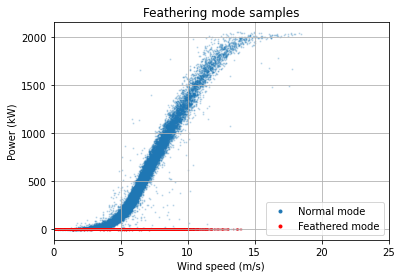

In [22]:
windspeed = turbine_data["Ws_avg"]
power_kw = turbine_data["P_avg"] # Put into kW

feathering = turbine_data[np.abs(turbine_data["Ba_avg"].values) >= 90]
non_feathering = turbine_data.loc[~turbine_data.index.isin(feathering.index)]
non_feathering.reset_index(inplace=True, drop=True)

plt.figure(figsize=(6,4))
plt.scatter(windspeed, power_kw, s = 1, alpha = 0.2, c='#1f77b4', label="Normal mode")
plt.scatter(feathering['Ws_avg'].values, feathering['P_avg'].values, s=1, alpha=0.5, c='red', label="Feathered mode")
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.xlim([0,25])
plt.title("Feathering mode samples")
plt.grid()
#leg = plt.legend(markerscale=3, bbox_to_anchor=(1.03, 1))
leg = plt.legend(markerscale=3)
leg.legendHandles[0].set_color('#1f77b4')
leg.legendHandles[0].set_alpha(1)
leg.legendHandles[1].set_color('red')
leg.legendHandles[1].set_alpha(1)
plt.savefig("feathering_samples.pdf", dpi=300, bbox_inches='tight')
plt.show()

windspeed_filt1 = non_feathering['Ws_avg']
power_kw_filt1 = non_feathering['P_avg']

In [23]:
feathering.shape

(6701, 35)

In [24]:
windspeed_filt1 = non_feathering['Ws_avg']
power_kw_filt1 = non_feathering['P_avg']

In [25]:
def bin_filter(bin_col, value_col, bin_width, threshold=2, center_type='mean', bin_min=None, bin_max=None,
               threshold_type='std', direction='all'):
    """Flag time stamps for which data in <value_col> when binned by data in <bin_col> into bins of <width>
    is outside <threhsold> bin. The <center_type> of each bin can be either the median or mean, and flagging
    can be applied directionally (i.e. above or below the center, or both)
    Args:
        bin_col(:obj:`pandas.Series`): data to be used for binning
        value_col(:obj:`pandas.Series`): data to be flagged
        bin_width(:obj:`float`): width of bin in units of bin_col
        threshold(:obj:`float`): outlier threshold (multiplicative factor of std of <value_col> in bin)
        bin_min(:obj:`float`): minimum bin value below which flag should not be applied
        bin_max(:obj:`float`): maximum bin value above which flag should not be applied
        threshold_type(:obj:`str`): option to apply a 'std' or 'scalar' based threshold
        center_type(:obj:`str`): option to use a 'mean' or 'median' center for each bin
        direction(:obj:`str`): option to apply flag only to data 'above' or 'below' the mean, otherwise the default is
        'all'
    Returns:
        :obj:`pandas.Series(bool)`: Array-like object with boolean entries.
    """

    # Set bin min and max values if not passed to function
    if bin_min is None:
        bin_min = bin_col.min()
    if bin_max is None:
        bin_max = bin_col.max()

    # Define bin edges
    bin_edges = np.arange(np.round(bin_min), np.round(bin_max), bin_width)

    # Ensure the last bin edge value is bin_max
    if bin_edges[-1] < bin_max:
        bin_edges = np.append(bin_edges, bin_max)
    elif bin_edges[-1] > bin_max:
        bin_edges[-1] = bin_max

    nbins = len(bin_edges) - 1  # Get number of bins

    # Define empty flag of 'False' values with indices matching value_col
    flag = pd.Series(index=value_col.index, data=False)

    # Loop through bins and applying flagging
    for n in np.arange(nbins):
        # Get data that fall wihtin bin
        y_bin = value_col.loc[(bin_col <= bin_edges[n + 1]) & (bin_col > bin_edges[n])]

        # Get center of binned data
        if center_type == 'mean':
            cent = y_bin.mean()
        elif center_type == 'median':
            cent = y_bin.median()
        else:
            print('incorrect center type specified')

        # Define threshold of data flag
        if threshold_type == 'std':
            ran = y_bin.std() * threshold
        elif threshold_type == 'scalar':
            ran = threshold

        # Perform flagging depending on specfied direction
        if direction == 'all':
            flag_bin = (y_bin > (cent + ran)) | (y_bin < (cent - ran))
        elif direction == 'above':
            flag_bin = y_bin > (cent + ran)
        elif direction == 'below':
            flag_bin = y_bin < (cent - ran)
        
        flag_bin = flag_bin[~flag_bin.index.duplicated()]
        # Record flags in final flag column
        flag.loc[flag_bin.index] = flag_bin

    return flag

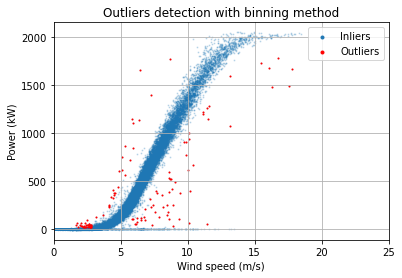

In [26]:
max_bin = 0.90*power_kw_filt1.max()
bin_outliers = bin_filter(power_kw_filt1, windspeed_filt1, 100, 1.5, 'median', 20., max_bin, 'scalar', 'all')

plt.figure(figsize=(6,4))
plt.scatter(windspeed_filt1, power_kw_filt1, s = 1, alpha = 0.2, label='Inliers')
plt.scatter(windspeed_filt1[bin_outliers], power_kw_filt1[bin_outliers], s = 1, c = 'red', label='Outliers')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.title("Outliers detection with binning method")
plt.xlim([0,25])
plt.grid()
leg = plt.legend(markerscale=3)
leg.legendHandles[0].set_color('#1f77b4')
leg.legendHandles[0].set_alpha(1)
leg.legendHandles[1].set_color('red')
leg.legendHandles[1].set_alpha(1)
plt.savefig("window_range_bin_filtering.pdf", dpi=300)
plt.show()

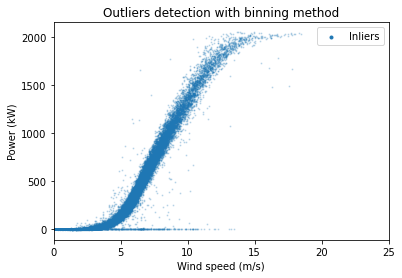

In [27]:
# MAKE FULL PICTURE
plt.figure(figsize=(6,4))
plt.scatter(windspeed_filt1, power_kw_filt1, s = 1, alpha = 0.2, label='Inliers')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.title("Outliers detection with binning method")
plt.xlim([0,25])

leg = plt.legend(markerscale=3)
leg.legendHandles[0].set_color('#1f77b4')
leg.legendHandles[0].set_alpha(1)
plt.savefig("bin_method_before_image.pdf", dpi=300)
plt.show()

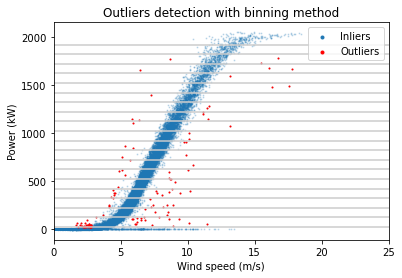

In [272]:
# MAKE FULL PICTURE
plt.figure(figsize=(6,4))
plt.scatter(windspeed_filt1, power_kw_filt1, s = 1, alpha = 0.2, label='Inliers')
plt.scatter(windspeed_filt1[bin_outliers], power_kw_filt1[bin_outliers], s = 1, c = 'red', label='Outliers')
[plt.axhline(y=i, c=(.8,.8,.8)) for i in [20,120,220,320,420,520,620,720,820,920,1020,1120,1220,1320,1420,1520,1620,1720,1820,1920]]
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.title("Outliers detection with binning method")
plt.xlim([0,25])

#plt.grid()
leg = plt.legend(markerscale=3)
leg.legendHandles[0].set_color('#1f77b4')
leg.legendHandles[0].set_alpha(1)
leg.legendHandles[1].set_color('red')
leg.legendHandles[1].set_alpha(1)
#plt.savefig("bin_method_image.png", dpi=1000)
plt.show()

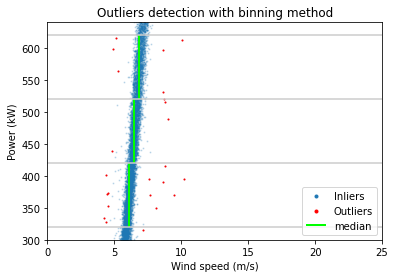

In [273]:
# GET MEDIANS FOR THE ZOOMED IN VERSIONS
idx1 = power_kw_filt1[(power_kw_filt1>320) & (power_kw_filt1<=420)].index
idx2 = power_kw_filt1[(power_kw_filt1>420) & (power_kw_filt1<=520)].index
idx3 = power_kw_filt1[(power_kw_filt1>520) & (power_kw_filt1<=620)].index
median1 = windspeed_filt1.loc[idx1].median()
median2 = windspeed_filt1.loc[idx2].median()
median3 = windspeed_filt1.loc[idx3].median()

# MAKE ZOOMED IN PICTURE
plt.figure(figsize=(6,4))
plt.scatter(windspeed_filt1, power_kw_filt1, s = 1, alpha = 0.2, label='Inliers')
plt.scatter(windspeed_filt1[bin_outliers], power_kw_filt1[bin_outliers], s = 1, c = 'red', label='Outliers')
[plt.axhline(y=i, c=(.8,.8,.8)) for i in [20,120,220,320,420,520,620,720,820,920,1020,1120,1220,1320,1420,1520,1620,1720,1820,1920]]
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.title("Outliers detection with binning method")
plt.xlim([0,25])
plt.axis([0, 25, 300, 640])
plt.vlines(median1, 320, 420, linestyles='solid', colors='lime', linewidth=2)
plt.vlines(median2, 420, 520, linestyles='solid', colors='lime', linewidth=2)
plt.vlines(median3, 520, 620, linestyles='solid', colors='lime', linewidth=2, label='median')


#plt.grid()
leg = plt.legend(markerscale=3, loc=4)
leg.legendHandles[0].set_color('#1f77b4')
leg.legendHandles[0].set_alpha(1)
leg.legendHandles[1].set_color('red')
leg.legendHandles[1].set_alpha(1)
#plt.savefig("bin_method_image_zoomed.png", dpi=1000)
plt.show()

In [274]:
bin_outliers[bin_outliers == True].shape

(122,)

In [275]:
no_outliers = non_feathering[~bin_outliers]
no_outliers.reset_index(inplace=True, drop=True)

# Remove unresponsive filter

In [276]:
frozen = filters.unresponsive_flag(no_outliers['Ws_avg'], 3)
no_outliers[frozen].shape

(75, 35)

In [277]:
only_responsive = no_outliers[~frozen]
only_responsive.reset_index(inplace=True, drop=True)

In [278]:
only_responsive.shape

(36673, 35)

# Add missing timestamps

In [279]:
only_responsive = only_responsive.set_index('Date_time', drop=True)
only_responsive = only_responsive.asfreq("1H")
only_responsive = only_responsive.reset_index()

# Save dataset

In [280]:
only_responsive.reset_index(inplace=True, drop=True)

In [281]:
only_responsive.head()

,Date_time,Ba_avg,Rt_avg,DCs_avg,Cm_avg,P_avg,Q_avg,S_avg,Cosphi_avg,Ds_avg,...,Va_avg,Ot_avg,Nf_avg,Nu_avg,Rs_avg,Rbt_avg,Rm_avg,Pas_avg,Wa_c_avg,Na_c_avg
0,2013-01-01 00:00:00+00:00,-0.958333,15.000000,1791.720000,5134.074950,965.223343,71.821666,968.036668,1.000000,1794.185000,...,8.893333,6.246667,50.001666,712.378335,17.123333,33.466667,5131.741667,NaN,193.481670,184.590000
1,2013-01-01 01:00:00+00:00,-0.968333,15.000000,1778.526650,5026.484950,939.466643,68.583333,942.116652,1.000000,1780.978317,...,-3.738333,6.330000,50.006666,714.023328,16.996667,33.598333,5017.901550,NaN,197.313337,200.446665
2,2013-01-01 02:00:00+00:00,-0.925000,15.000000,1783.525000,5980.278250,1119.698338,84.603333,1123.209980,0.998333,1785.993367,...,-7.025000,5.731667,50.003333,707.593343,17.043333,33.713334,5966.116700,NaN,194.025005,201.050000
3,2013-01-01 03:00:00+00:00,-0.786667,15.000000,1795.631667,7242.248367,1360.543317,111.818333,1365.536700,0.996667,1798.105000,...,2.456667,5.030000,49.998334,710.711680,17.160000,33.546667,7224.125083,NaN,187.033335,185.820000
4,2013-01-01 04:00:00+00:00,0.223333,15.743333,1794.431683,8925.688467,1673.701683,122.359998,1678.528333,1.000000,1796.866650,...,1.811667,4.941667,49.993334,713.678335,17.150000,33.591667,8892.183433,NaN,186.393335,184.590000


In [282]:
only_responsive.shape

(43824, 35)

In [283]:
# define directory to save
import os
PATH_TO_DIR = '../datasets/after_outlier_removal'

# create directory if it does not exists
if not os.path.exists(PATH_TO_DIR):
    os.makedirs(PATH_TO_DIR)

# save
PATH_TO_SAVE = os.path.join(PATH_TO_DIR, 'turbine_{}.csv'.format(label_name))
only_responsive.to_csv(PATH_TO_SAVE, sep='\t', index=False, encoding='utf-8')